In [1]:
%pylab inline
import string
import pandas as pd
import bs4
import requests

Populating the interactive namespace from numpy and matplotlib


In [141]:
class Pokemon:
    def __init__(self):
        self.catch_rate = random.random()
        self.name = self.gen_name()
        
    def __repr__(self):
        return self.name
        
    

In [2]:
url = 'https://bulbapedia.bulbagarden.net/wiki/List_of_moves'
response = requests.get(url)
soup = bs4.BeautifulSoup(response.content)

In [4]:
import requests
def scrape_tables(url, thresh=1):
    #From https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html
    #Pretend to be a browser
    header = {
              "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
              "X-Requested-With": "XMLHttpRequest"
              }
    r = requests.get(url, headers=header)
    dfs = pd.read_html(r.text)
    
    #Only return DF if more than one row.
    return [d for d in dfs if len(d)>thresh]
    
    

In [6]:
df = scrape_tables(url)[0]

In [7]:
df.columns

Index(['#', 'Name', 'Type', 'Category', 'Contest', 'PP', 'Power', 'Accuracy',
       'Gen'],
      dtype='object')

In [8]:
def to_type(x,type_):
    try:
        cast = type_(x)
        return cast
    except:
        return None

In [9]:
df.PP = df.PP.apply(lambda x: to_type(x,int))

In [10]:
df.Power = df.Power.apply(lambda x: to_type(x,int))

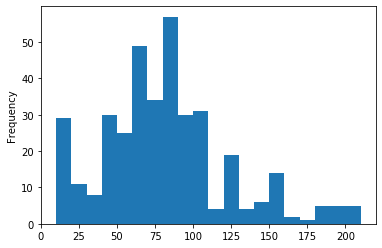

In [11]:
df.Power.plot.hist(bins=20)


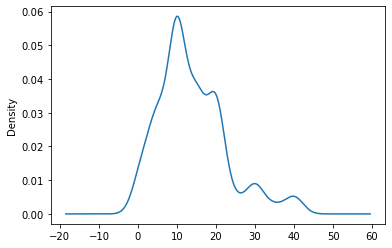

In [12]:
df.PP.plot.kde()

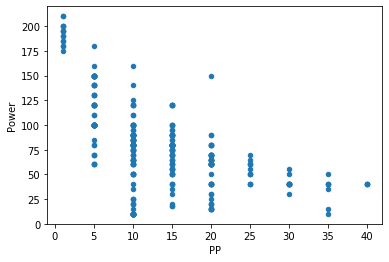

In [13]:
df.plot.scatter('PP','Power')

In [14]:
df.dropna().sample(4)

,#,Name,Type,Category,Contest,PP,Power,Accuracy,Gen
61,62,Aurora Beam,Ice,Special,Beautiful,20.0,65.0,100%,I
526,527,Electroweb,Electric,Special,Beautiful,15.0,55.0,95%,V
69,70,Strength,Normal,Physical,Tough,15.0,80.0,100%,I
608,609,Nuzzle,Electric,Physical,Cute,20.0,20.0,100%,VI


In [15]:
dfs = scrape_tables('https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_National_Pok%C3%A9dex_number')

In [16]:
names = pd.concat(dfs[:-1], axis=0)['Pokémon'].drop_duplicates().reset_index(drop=True)

/Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [17]:
from tqdm import tqdm

class MarkovSeqGen:
    def __init__(self, seqs, start='>', stop='|'):
        self.seqs = pd.Series(seqs)
        self.start = start
        self.stop = stop
        self.seqs = self.seqs.apply(lambda x: self.start + x + self.stop)
        self.chars = sorted(set(''.join(self.seqs)))

        self.c_to_i = {c: i for i, c in enumerate(self.chars)}
        self.i_to_c = {v: k for k, v in self.c_to_i.items()}

        self.tmat = self.encode_tmat()

    def encode_tmat(self):
        tmat = np.zeros((len(self.chars), len(self.chars)))
        for n, seq in tqdm(enumerate(self.seqs)):
            for cidx, c in enumerate(seq):
                if cidx > 0:
                    a = seq[cidx - 1]
                    b = seq[cidx]
                    i = self.c_to_i[a]
                    j = self.c_to_i[b]
                    tmat[i, j] += 1
        return tmat

    def gen(self, n):
        seqs = []
        for _ in range(n):
            res = ''
            res += self.start
            curr = res[-1]
            while curr != self.stop:
                cur_i = self.c_to_i[curr]
                distrib = self.tmat[cur_i]
                distrib /= distrib.sum()
                res += np.random.choice(self.chars, p=distrib)
                curr = res[-1]
            seqs.append(res[1:-1])
        return seqs

In [21]:
gen = MarkovSeqGen(names)
gen.gen(5)

890it [00:00, 108654.40it/s]


['Barthina', 'Waifer', 'Riule', 'Cosktchyurra', 'Goun']

In [23]:
import sng

Using TensorFlow backend.
/Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mgbvox/anaconda3/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [30]:
%load_ext autoreload
%autoreload 2

In [31]:
cfg = sng.Config(
    epochs=50,
    n_layers=10,
    hidden_dim=150,
    
)
cfg.to_dict()

{'debug': True,
 'verbose': True,
 'epochs': 50,
 'batch_size': 64,
 'n_layers': 2,
 'hidden_dim': 50,
 'min_word_len': 4,
 'max_word_len': 12,
 'temperature': 1.0,
 'suffix': ''}

In [38]:
gen = sng.Generator(wordlist=list(names), config=cfg)

890 words

62 characters, including the \n:
['\n', ' ', "'", '-', '.', '2', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '♀', '♂']

First two sample words:
['Shaymin\n', 'Lampent\n']


In [39]:
gen.fit()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
epoch 0 words: UHACIMna, C.Rcaéh, EpsP, QSNa♀'qJh, loss: 2.4864
epoch 10 words: Jiegizn, Oprnloor, Fore, Oisreig, loss: 1.8058
epoch 20 words: Zhciuidin, Oeltsolbcst, Vayyolu, Qgaencr, loss: 1.7456
epoch 30 words: Flkioed, Aktuvrlst, Rgagc, AJroler, loss: 1.7102
epoch 40 words: Eulgea, Raafailh, Parbex, Rorogreb, loss: 1.6294
